This model is our most succesful one with transfer learning. We use the efficientnet architecture, near to state of the art in classification task without exceptionally large number of parameters. We have to install it from the web and we use the B5 one, best compromise between speed and accuracy. We reached a score of 0.96888 in the test set.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

We import libraries, set the seed and the working directory.

In [2]:
import os
import tensorflow as tf
import numpy as np

SEED = 27091997
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We build the generator, we decide the splitting into training and validation set and we augment the training data with only the "admissible" tranformations(for example no vertical flip).
Augmentation doesn't influence too much the model, but it's slightly better because of the scarcity of data.
Proportion of validation is low but enough to be reliable, and we use the most we can for training.

In [4]:
# ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(width_shift_range=15,
                                        height_shift_range=15,
                                        zoom_range=[0.7, 1.3],
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1./255,
                                        rotation_range=10, 
                                        shear_range=10,                                      
                                        validation_split = 0.1)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255,
                                        validation_split = 0.1)


We import the data and we create a dataframe with the images and their lables.

In [5]:
#Fix the directory structure
import pandas as pd
import json

# unzip 
!unzip '/content/drive/My Drive/artificial-neural-networks-and-deep-learning-2020.zip'

# setting the diectory 
dataset_dir = os.path.join(cwd,'MaskDataset')

# image classes
with open(os.path.join(dataset_dir,'train_gt.json')) as f:
  dic = json.load(f)
dataframe = pd.DataFrame(dic.items())

# create and shuffle dataframe
dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)
dataframe['class'] = dataframe['class'].astype(str)
dataframe = dataframe.sample(frac=1,random_state=27091997).reset_index(drop=True)

Output streaming troncato alle ultime 5000 righe.
  inflating: MaskDataset/training/10891.jpg  
  inflating: MaskDataset/training/10892.jpg  
  inflating: MaskDataset/training/10894.jpg  
  inflating: MaskDataset/training/10899.jpg  
  inflating: MaskDataset/training/10901.jpg  
  inflating: MaskDataset/training/10902.jpg  
  inflating: MaskDataset/training/10905.jpg  
  inflating: MaskDataset/training/10906.jpg  
  inflating: MaskDataset/training/10907.jpg  
  inflating: MaskDataset/training/10908.jpg  
  inflating: MaskDataset/training/10911.jpg  
  inflating: MaskDataset/training/10913.jpg  
  inflating: MaskDataset/training/10915.jpg  
  inflating: MaskDataset/training/10916.jpg  
  inflating: MaskDataset/training/10917.jpg  
  inflating: MaskDataset/training/10919.jpg  
  inflating: MaskDataset/training/10920.jpg  
  inflating: MaskDataset/training/10921.jpg  
  inflating: MaskDataset/training/10922.jpg  
  inflating: MaskDataset/training/10923.jpg  
  inflating: MaskDataset/train

We define the batch size, we fix the dimensions of the images and the number of classes.

In [6]:
# batch size (Small because with more than this we get OOM error)
bs = 6

# img shape (original dimensions of images used for training EfficientnetB5). We think that by using the original size it can capture better features
img_h = 456
img_w = 456

# classes
num_classes=3

We read the images from the dataframe created before.

In [7]:
# Training
training_dir = os.path.join(dataset_dir, 'training')

train_gen = train_data_gen.flow_from_dataframe(dataframe,
                                               training_dir,
                                               x_col = 'filename',
                                               y_col = 'class',
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training',
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
valid_gen = train_data_gen.flow_from_dataframe(dataframe,
                                               training_dir,
                                               x_col = 'filename',
                                               y_col = 'class',
                                               batch_size=bs, 
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='validation',
                                               seed=SEED)


Found 5053 validated image filenames belonging to 3 classes.
Found 561 validated image filenames belonging to 3 classes.


Now we can use the defined generators. Set on repeat in order to reuse the same images.

In [8]:
#We now finally get the training and validation datasets from the generators

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
# Repeat
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
valid_dataset = valid_dataset.repeat()

We look at the images in one of the batches to see if there are errors and to grasp possible challenges of the problem.

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(6, 456, 456, 3)

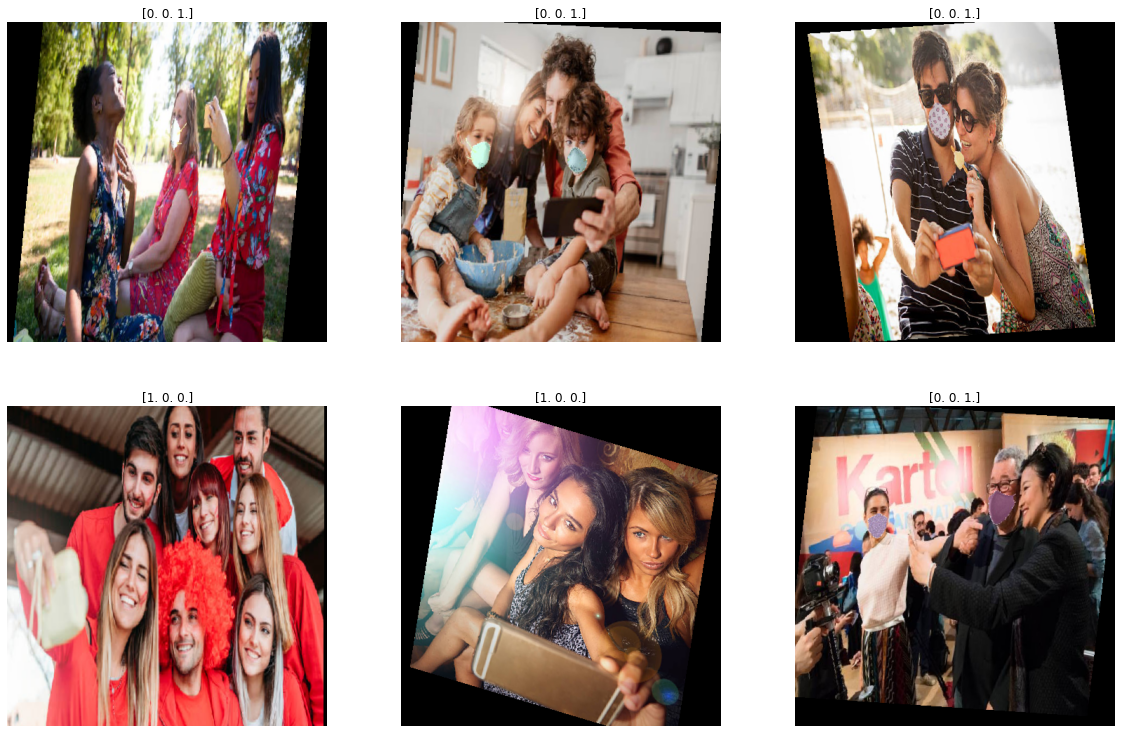

In [9]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,20))
  for n in range(bs):
      ax = plt.subplot(bs/2,bs/2,n+1)
      plt.imshow(image_batch[n])
      plt.title(label_batch[n])
      plt.axis('off')

image_batch, label_batch = next(valid_gen)
show_batch(image_batch, label_batch)
image_batch.shape

We install efficientnet in order to use it for transfer learning.

In [10]:
!pip install efficientnet
import efficientnet.tfkeras as efn 

     |████████████████████████████████| 51kB 7.4MB/s 


Now we create the model. We use Imagenet weights but since the task is pretty different from that one we finetune the model. In particular, we discovered that a complete finetune (freeze=0) works the best, thanks to the very different nature of the problem and so of the useful features.
At the end there's a global average pooling to reduce the size, a batch normalization to control the outputs, and a dropout to prevent overfitting.

In [11]:
# Create Model
# ------------
arch = efn.EfficientNetB5(include_top=False, weights='imagenet', input_shape=(img_h, img_w, 3))

finetuning = True  #We are adapting the parameters to our problem

if finetuning:
    freeze_until = 0 # layer from which we want to fine-tune
    
    for layer in arch.layers[:freeze_until]:
        layer.trainable = False
else:
    arch.trainable = False
    
model = tf.keras.Sequential()
model.add(arch)
model.add(tf.keras.layers.GlobalAveragePooling2D(data_format=None))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# Visualize created model as a table
model.summary()


115515392/115515256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 15, 15, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 28,527,859
Trainable params: 28,351,027
Non-trainable params: 176,832
_________________________________________________________________


We compile the model

In [12]:
# Optimization params

# Loss
loss = tf.keras.losses.CategoricalCrossentropy() # Standard choice

# learning rate 
lr = 1e-4   # After some trials, we have found this lr to be good enough to train quickly 
            # without oscillating too much around the final solution

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)  


# Validation metrics
metrics = ['accuracy'] #Choice for the challenge


# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


We add some callbacks: early stopping to stop overfit and the learning rate adapter to refine search for minima during training. Then we train the model. (Normally it stops much before 80 epochs). It takes around 5 hours on colab GPU.

In [13]:
# earlystopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,restore_best_weights=True)
# learning rate adapter callback
LR_adapter_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, mode='auto', min_delta=0.0001, cooldown=0)
    
model.fit(x=train_dataset,
          epochs=80,  
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=[es_callback,LR_adapter_callback],
          verbose = 1) #We like to monitor the accuracy during training live ()

Epoch 1/80
843/843 [==============================] - 934s 1s/step - loss: 1.0245 - accuracy: 0.6357 - val_loss: 0.4060 - val_accuracy: 0.8342
Epoch 2/80
843/843 [==============================] - 939s 1s/step - loss: 0.6297 - accuracy: 0.7667 - val_loss: 0.2125 - val_accuracy: 0.9162
Epoch 3/80
843/843 [==============================] - 936s 1s/step - loss: 0.4501 - accuracy: 0.8355 - val_loss: 0.2000 - val_accuracy: 0.9216
Epoch 4/80
843/843 [==============================] - 935s 1s/step - loss: 0.3644 - accuracy: 0.8710 - val_loss: 0.1310 - val_accuracy: 0.9554
Epoch 5/80
843/843 [==============================] - 939s 1s/step - loss: 0.3139 - accuracy: 0.8896 - val_loss: 0.1178 - val_accuracy: 0.9590
Epoch 6/80
843/843 [==============================] - 937s 1s/step - loss: 0.2662 - accuracy: 0.9119 - val_loss: 0.1113 - val_accuracy: 0.9626
Epoch 7/80
843/843 [==============================] - 937s 1s/step - loss: 0.2332 - accuracy: 0.9218 - val_loss: 0.1067 - val_accuracy: 0.9697

In [ ]:
# We save the model to reuse it in the final ensemble
model.save(os.path.join('/content/drive/My Drive/modelloEfficientNetB5'))

Now we make predictions on the test set and we create a csv file with the results.

In [14]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [15]:
from PIL import Image
image_filenames = next(os.walk(os.path.join(dataset_dir, 'test')))[2]

results = {}
for image_name in image_filenames:

   img = Image.open(os.path.join(dataset_dir, 'test')+'/'+image_name).convert('RGB')
   img=img.resize((img_h, img_w))
   img_array = np.array(img)
   img_array = np.expand_dims(img_array, 0) 
   img_array = np.true_divide(img_array,255)
   predictions=model.predict(img_array)
   prediction = np.argmax(predictions)   # predicted class
   results[image_name] = prediction

create_csv(results, '/content/drive/My Drive')